### Installations, if needed

In [ ]:
!pip install spacy==2.0.12 # Above 2.0.12 doesn't seem work with the neuralcoref resolution (at least 2.0.13 and 2.0.16 don't)
!pip install https://github.com/huggingface/neuralcoref-models/releases/download/en_coref_md-3.0.0/en_coref_md-3.0.0.tar.gz # This is the coref language model
!pip install networkx
!pip install pydot # To draw our graphs in graphviz
!pip install graphviz

### Imports & Loading Files

In [3]:
import spacy
from spacy import displacy
from collections import Counter
import re
import os
import pandas as pd
import networkx as nx
import sys
import pydot
import matplotlib.pyplot as plt
#import graphviz
from graphviz import Source

TEXT_FILENAME = 'TheOrange.txt'

with open(TEXT_FILENAME, 'rb') as raw_text:
    text = raw_text.read().strip().decode('utf-8',errors='replace')

### Cleaning text

In [4]:
# Can uncomment the below if Harry Potter & removing title.
#text = text[39:]

cleaned_text = re.sub(r'(?:[A-Z]{2,}\s+)','',text).strip()
cleaned_text=re.sub(r'\s+',' ',cleaned_text)

# Can uncomment if lowercase is desired
#cleaned_text = text.lower()

### Loading and running SpaCy English Medium-Sized Pipeline

In [ ]:
# Download the english medium-sized pipeline
! python -m spacy download en_core_web_md

### Viewing the text, with highlighted named entities

In [ ]:
displacy.render(doc, jupyter=True, style='ent')

That is cool, but it won't help us in this project, since the main characters are not named, and thus aren't noticed. We'd be better off building for this case something that looks for a DT NN* pattern in the POS tags, and then keeps it if it's referenced x number of times.

### Coreference Resolution

Using the NeuralCoref library: https://github.com/huggingface/neuralcoref
(If I can ever get it to work, which so far I cannot.)

This needs to happen earlier, before the graph. Lots of unexpected pronoun confusion happening.

In [78]:
nlp_coref = spacy.load('en_coref_md')
doc = nlp_coref(cleaned_text)

In [80]:
doc._.coref_clusters

[An orange: [An orange, It],
 Airplane pilots passing over: [Airplane pilots passing over, their, us],
 the grove: [the grove, the grove],
 their passengers: [their passengers, the passengers],
 the orange: [the orange, the orange, the orange who ruled the world, the orange, The orange, They, the orange],
 none of the migrant workers: [none of the migrant workers, they],
 The other oranges: [The other oranges, they],
 Finally a man from Chicago, with a heart as windy and cold as Lake Michigan in wintertime: [Finally a man from Chicago, with a heart as windy and cold as Lake Michigan in wintertime, He, his, the man],
 Chicago: [Chicago, Chicago],
 truck drivers: [truck drivers, their],
 he: [he, he, him],
 we: [we, our]]

In [41]:
coreferenced_text = doc._.coref_resolved

In [42]:
# Use that file to process the text into a doc.
nlp = spacy.load('en_core_web_md')
doc = nlp(coreferenced_text)

In [43]:
print(doc)

An orange ruled the world. An orange was an unexpected thing, the temporary abdication of Heavenly Providence, entrusting the whole matter to a simple orange. The orange, in a grove in Florida, humbly accepted the honor. The other oranges, the birds, and the men in their tractors wept with joy; the tractors' motors rumbled hymns of praise. Airplane pilots passing over would circle the grove and tell Airplane pilots passing over passengers, "Below Airplane pilots passing over is the grove where the orange who rules the world grows on a simple branch." And their passengers would be silent with awe. The governor of Florida declared every day a holiday. On summer afternoons the Dalai Lama would come to the grove and sit with the orange, and talk about life. When the time came for the orange to be picked, none of the migrant workers would do it: none of the migrant workers went on strike. The foremen wept. The other oranges swore The other oranges would turn sour. But the orange said, "No, 

### Viewing dependencies

In [44]:
sentence_spans = list(doc.sents)
displacy.render(sentence_spans[1], jupyter=True, style='dep')

### Creating a Graph with a node for each noun phrase

In [65]:
# Establish our graph using Networkx
G = nx.Graph()

### Sorting prepositional phrases
This needs to happen along with the adjective removal before we've totally decimated the text.


In [46]:
last_span_end = 0
simplified_text = []

for chunk in doc.noun_chunks:
    G.add_node(chunk.root.text)
    for token in chunk:
        if (token.text != chunk.root.text) and (token.pos_ in {'ADJ', 'NOUN', 'PROPN'}):
            G.add_node(token.text)
            G.add_node(token.head.text)
            G.add_edge(token.text, token.head.text, label=token.pos_)
    this_span_start = chunk.start
    simplified_text.append("{0} {1}".format(doc[last_span_end:this_span_start].text,chunk.root.text))
    last_span_end = chunk.end
    
simplified_text.append(doc[last_span_end:].text)

In [47]:
simplified_text = " ".join(simplified_text)
simplified_text_filename = TEXT_FILENAME.split('.')[0] + "_simplified.txt"

with open(simplified_text_filename, 'w') as file:
    text = file.write(simplified_text.strip())

### Extracting Triples with ReVerb
From http://reverb.cs.washington.edu/ (and used in the paper "Information retrieval in folktales using natural
language processing": https://arxiv.org/pdf/1511.03012.pdf)

In [64]:
# Preparing the filename for the tab-separated values output of ReVerb
tsv_filename = TEXT_FILENAME.split('.')[0] + "_ReVerb.tsv"

# Run the Java package. Java JDK is required to be installed from
# https://www.oracle.com/technetwork/java/javase/downloads/jdk11-downloads-5066655.html
os.system("java -Xmx512m -jar reverb-latest.jar -a {0} > {1}".format(TEXT_FILENAME, tsv_filename))

# Reading the results from the Java executable into a Pandas dataframe.
reverb_results = pd.read_csv(tsv_filename, header=None, sep='\t')
reverb_results.columns = ['filename','Sentence_Num','Arg1','Rel','Arg2','Arg1_StartInd','Arg1_EndInd','Rel_StartInd','Rel_EndInd', 'Arg2_StartInd','Arg2_EndInd', 'Confidence','Sent_Text', 'Sent_POS','Sent_ChunkTags', 'Arg1_Norm', 'Rel_Norm', 'Arg2_Norm']

# Set the option to not truncate the text in longer cells
pd.set_option('display.max_colwidth', -1)

In [56]:
# Exploring the dataframe
reverb_results

,filename,Sentence_Num,Arg1,Rel,Arg2,Arg1_StartInd,Arg1_EndInd,Rel_StartInd,Rel_EndInd,Arg2_StartInd,Arg2_EndInd,Confidence,Sent_Text,Sent_POS,Sent_ChunkTags,Arg1_Norm,Rel_Norm,Arg2_Norm
0,/Users/andrewlarimer/Dropbox/Berkeley/W266_NLP/FinalProject/TheOrange.txt,1,An orange,ruled,the world,0,2,2,3,3,5,8.842261e-01,An orange ruled the world .,DT NN VBD DT NN .,B-NP I-NP B-VP B-NP I-NP O,an orange,rule,the world
1,/Users/andrewlarimer/Dropbox/Berkeley/W266_NLP/FinalProject/TheOrange.txt,2,It,was,an unexpected thing,0,1,1,2,2,5,7.216376e-01,"It was an unexpected thing , the temporary abdication of Heavenly Providence , entrusting the whole matter to a simple orange .","PRP VBD DT JJ NN , DT JJ NN IN NNP NNP , VBG DT JJ NN TO DT JJ NN .",B-NP B-VP B-NP I-NP I-NP O B-NP I-NP I-NP I-NP I-NP I-NP O B-VP B-NP I-NP I-NP B-PP B-NP I-NP I-NP O,it,be,an unexpected thing
2,/Users/andrewlarimer/Dropbox/Berkeley/W266_NLP/FinalProject/TheOrange.txt,2,It,was,the temporary abdication of Heavenly Providence,0,1,1,2,6,12,7.212156e-01,"It was an unexpected thing , the temporary abdication of Heavenly Providence , entrusting the whole matter to a simple orange .","PRP VBD DT JJ NN , DT JJ NN IN NNP NNP , VBG DT JJ NN TO DT JJ NN .",B-NP B-VP B-NP I-NP I-NP O B-NP I-NP I-NP I-NP I-NP I-NP O B-VP B-NP I-NP I-NP B-PP B-NP I-NP I-NP O,it,be,the temporary abdication of heavenly providence
3,/Users/andrewlarimer/Dropbox/Berkeley/W266_NLP/FinalProject/TheOrange.txt,3,"The orange , in a grove in Florida",humbly accepted,the honor,0,8,9,11,11,13,3.339789e-01,"The orange , in a grove in Florida , humbly accepted the honor .","DT NN , IN DT NN IN NNP , RB VBD DT NN .",B-NP I-NP O B-PP B-NP I-NP B-PP B-NP O B-VP I-VP B-NP I-NP O,"the orange , in a grove in florida",accept,the honor
4,/Users/andrewlarimer/Dropbox/Berkeley/W266_NLP/FinalProject/TheOrange.txt,4,the tractors ' motors,rumbled,hymns of praise,17,21,21,22,22,25,6.027375e-01,"The other oranges , the birds , and the men in their tractors wept with joy ; the tractors ' motors rumbled hymns of praise .","DT JJ NNS , DT NNS , CC DT NNS IN PRP$ NNS VBN IN NN : DT NNS POS NNS VBD NNS IN NN .",B-NP I-NP I-NP O B-NP I-NP O O B-NP I-NP B-PP B-NP I-NP B-VP B-PP B-NP O B-NP I-NP I-NP I-NP B-VP B-NP I-NP I-NP O,the tractors ' motors,rumble,hymns of praise
5,/Users/andrewlarimer/Dropbox/Berkeley/W266_NLP/FinalProject/TheOrange.txt,5,Airplane pilots,tell,their passengers,0,2,9,10,10,12,5.304418e-01,"Airplane pilots passing over would circle the grove and tell their passengers , "" Below us is the grove where the orange who rules the world grows on a simple branch . ""","NNP NNS VBG RB MD VB DT NN CC VB PRP$ NNS , '' IN PRP VBZ DT NN WRB DT NN WP VBZ DT NN VBZ IN DT JJ NN . ''",B-NP I-NP B-VP B-ADVP B-VP I-VP B-NP I-NP O B-VP B-NP I-NP O O B-SBAR B-NP B-VP B-NP I-NP B-ADVP B-NP I-NP B-NP B-VP B-NP I-NP B-VP B-PP B-NP I-NP I-NP O O,airplane pilots,tell,their passengers
6,/Users/andrewlarimer/Dropbox/Berkeley/W266_NLP/FinalProject/TheOrange.txt,5,us,is,the grove where the orange who rules the world grows on a simple branch,15,16,16,17,17,31,5.712114e-01,"Airplane pilots passing over would circle the grove and tell their passengers , "" Below us is the grove where the orange who rules the world grows on a simple branch . ""","NNP NNS VBG RB MD VB DT NN CC VB PRP$ NNS , '' IN PRP VBZ DT NN WRB DT NN WP VBZ DT NN VBZ IN DT JJ NN . ''",B-NP I-NP B-VP B-ADVP B-VP I-VP B-NP I-NP O B-VP B-NP I-NP O O B-SBAR B-NP B-VP B-NP I-NP B-ADVP B-NP I-NP B-NP B-VP B-NP I-NP B-VP B-PP B-NP I-NP I-NP O O,us,be,the grove where the orange who rules the world grows on a simple branch
7,/Users/andrewlarimer/Dropbox/Berkeley/W266_NLP/FinalProject/TheOrange.txt,5,the orange,rules,the world,20,22,23,24,24,26,1.223496e-13,"Airplane pilots passing over would circle the grove and tell their passengers , "" Below us is the grove where the orange who rules the world grows on a simple branch . ""","NNP NNS VBG RB MD VB DT NN CC VB PRP$ NNS , '' IN PR

### Graphing

#### Converting triples to graph nodes and edges

In [74]:
def create_nodes_and_edge(row):
    arg1_text = row['Arg1'].split(' ')
    arg1_pos = row['Sent_POS'].split(' ')[int(row['Arg1_StartInd']):int(row['Arg1_EndInd'])]
    print(arg1_text)
    print(arg1_pos)
    G.add_node(row['Arg1'])
    G.add_node(row['Arg2'])
    G.add_edge(row['Arg1'], row['Arg2'], label=row['Rel'])

In [75]:
_ = reverb_results.apply(lambda x: create_nodes_and_edge(x), axis=1)

['An', 'orange']
['DT', 'NN']
['It']
['PRP']
['It']
['PRP']
['The', 'orange', ',', 'in', 'a', 'grove', 'in', 'Florida']
['DT', 'NN', ',', 'IN', 'DT', 'NN', 'IN', 'NNP']
['the', 'tractors', "'", 'motors']
['DT', 'NNS', 'POS', 'NNS']
['Airplane', 'pilots']
['NNP', 'NNS']
['us']
['PRP']
['the', 'orange']
['DT', 'NN']
['the', 'orange', 'who', 'rules', 'the', 'world']
['DT', 'NN', 'WP', 'VBZ', 'DT', 'NN']
['the', 'passengers']
['DT', 'NNS']
['The', 'governor', 'of', 'Florida']
['DT', 'NN', 'IN', 'NNP']
['the', 'Dalai', 'Lama']
['DT', 'NNP', 'NNP']
['the', 'Dalai', 'Lama']
['DT', 'NNP', 'NNP']
['the', 'Dalai', 'Lama']
['DT', 'NNP', 'NNP']
['the', 'time']
['DT', 'NN']
['none', 'of', 'the', 'migrant', 'workers']
['NN', 'IN', 'DT', 'JJ', 'NNS']
['they']
['PRP']
['The', 'other', 'oranges']
['DT', 'JJ', 'NNS']
['the', 'orange']
['DT', 'NN']
['it']
['PRP']
['He']
['PRP']
['his', 'briefcase']
['PRP$', 'NN']
['He']
['PRP']
['The', 'birds']
['DT', 'NNS']
['The', 'orange']
['DT', 'NN']
['the', 'orange

AttributeError: ("'float' object has no attribute 'split'", 'occurred at index 34')

#### Draw the graph

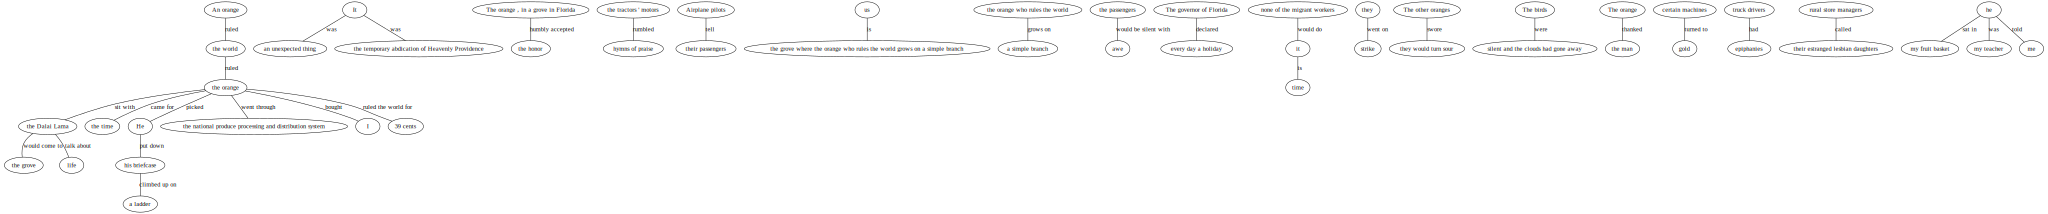

In [76]:
# Write our graph to DOT format to be read and visualized by GraphViz
nx.drawing.nx_pydot.write_dot(G,'graph_dot.txt')

graph_filename = TEXT_FILENAME.split('.')[0] + '_Graph'

# Load the saved DOT format
graph_visualized = Source.from_file('graph_dot.txt')

# Save it to a png
graph_visualized.render(filename=graph_filename, format='png')

# View it in the notebook
graph_visualized